# PREDICCION DE FASE USANDO NPL

## 1. Preparacion

### 1.1 Importe De Librerias

In [264]:
import pandas as pd
import numpy as np
from numpy import loadtxt
from pylab import *
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell  
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, HTML
from scipy import stats
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
from statistics import mean

import re
import nltk
nltk.download('stopwords')
import pickle
from nltk.corpus import stopwords
from sklearn import preprocessing
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.model_selection import RandomizedSearchCV
import pickle
import nltk
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix

[nltk_data] Downloading package stopwords to C:\Users\Diego
[nltk_data]     Ojeda\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### 1.2 Carga de Base De Datos

In [265]:
path='Data.xlsx'
base = pd.read_excel(path)
data = base

In [266]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27185 entries, 0 to 27184
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Siglas        27185 non-null  object        
 1   Nombre        27185 non-null  object        
 2   Desde         27184 non-null  datetime64[ns]
 3   Hasta         27184 non-null  datetime64[ns]
 4   MD From (ft)  26180 non-null  float64       
 5   MD to (ft)    26162 non-null  float64       
 6   Codigo        27185 non-null  object        
 7   Subcodigo     26936 non-null  float64       
 8   Operación     27180 non-null  object        
dtypes: datetime64[ns](2), float64(3), object(4)
memory usage: 1.9+ MB


### 1.3 Limpieza Y Organizacion De Base De Datos

In [267]:
# Eliminación de filas con datos nulos
data = data.dropna()
data = data.reset_index(drop=True)

# Funcion para calcular diferencias de dos fechas
def date_diff(date1, date2):
    return (date1 -  date2).total_seconds()/60/60

# Creacion de columna con la duracion de la actividad
data["Duracion"] = [date_diff(data.Hasta[i],data.Desde[i]) for i in range(len(data))]

# Funcion para caclular al media entre dos profundidades
def MD_Mean(MD_F,MD_T):
    return mean([MD_T,MD_F])

# Creacion de columna con la media de la profundidad en la actividad
data["MD_Mean"] = [MD_Mean(data["MD to (ft)"][i],data["MD From (ft)"][i]) for i in range(len(data))]

# Cambio de tipo de datos de las columnas
data['Subcodigo'] = data['Subcodigo'].astype(np.int64)
data['Codigo'] = data['Codigo'].astype(np.int64)

In [268]:
data

,Siglas,Nombre,Desde,Hasta,MD From (ft),MD to (ft),Codigo,Subcodigo,Operación,Duracion,MD_Mean
0,ODR,MOR BL 04,2011-05-25 08:00:00,2011-05-25 11:00:00,2773.0,2773.0,1300,1304,"HANG TBG ON 7 1/16"" CASING HEAD. DISCONNECTED ...",3.0,2773.0
1,ODR,MOR BL 04,2011-05-25 02:30:00,2011-05-25 08:00:00,2773.0,2773.0,1100,1117,"RIH 2 7 /8"" TUBING EUE (31.62 FT) + NIPLESILL...",5.5,2773.0
2,ODR,MOR BL 04,2011-05-25 00:00:00,2011-05-25 02:30:00,2773.0,2773.0,1100,1116,CONTD. POOH AND L/D 3 1/2'' DP + SETTING TOOL ...,2.5,2773.0
3,ODR,MOR BL 04,2011-05-24 00:00:00,2011-05-24 03:30:00,2773.0,2773.0,1500,1503,"GRAVEL PACKING 5½"" LINER W/ 10-16 MESH GRAVEL ...",3.5,2773.0
4,ODR,MOR BL 04,2011-05-24 21:30:00,2011-05-24 22:30:00,2773.0,2773.0,1500,1503,CONDITIONED BRINE TO 9.5 PPG AND CIRCULATED AN...,1.0,2773.0
...,...,...,...,...,...,...,...,...,...,...,...
25915,ODR,MOR D 02,2009-08-22 11:00:00,2009-08-22 13:00:00,2907.0,2907.0,2100,2104,PERFORM PRESURE LINE TEST W 4000 PSI. PUMPED...,2.0,2907.0
25916,ODR,MOR D 02,2009-08-22 17:30:00,2009-08-22 19:00:00,2907.0,2907.0,1500,1503,CONDITIONED BRINE TO PERFORM CEMENT JOB,1.5,2907.0
25917,ODR,MOR D 02,2009-08-22 10:00:00,2009-08-22 10:30:00,2907.0,2907.0,1700,1701,HELD PREOPERATIONAL METTING TO SET PACKER STAG...,0.5,2907.0
25918,ODR,MOR D 02,2009-08-23 00:00:00,2009-08-23 03:30:00,2907.0,2907.0,2100,2104,"HELD PREOPERATIONAL MEETING TO 7"" CASING CEMEN...",3.5,2907.0


In [269]:
# Eliminacion de columnas innecesarias y cambio de nombre de columnas
data = data.drop(['Desde', 'Hasta',"MD From (ft)","MD to (ft)","Nombre"], axis=1)
data = data.rename({'Operación':"Operacion"}, axis=1)

In [270]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25920 entries, 0 to 25919
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Siglas     25920 non-null  object 
 1   Codigo     25920 non-null  int64  
 2   Subcodigo  25920 non-null  int64  
 3   Operacion  25920 non-null  object 
 4   Duracion   25920 non-null  float64
 5   MD_Mean    25920 non-null  float64
dtypes: float64(2), int64(2), object(2)
memory usage: 1.2+ MB


In [271]:
data

,Siglas,Codigo,Subcodigo,Operacion,Duracion,MD_Mean
0,ODR,1300,1304,"HANG TBG ON 7 1/16"" CASING HEAD. DISCONNECTED ...",3.0,2773.0
1,ODR,1100,1117,"RIH 2 7 /8"" TUBING EUE (31.62 FT) + NIPLESILL...",5.5,2773.0
2,ODR,1100,1116,CONTD. POOH AND L/D 3 1/2'' DP + SETTING TOOL ...,2.5,2773.0
3,ODR,1500,1503,"GRAVEL PACKING 5½"" LINER W/ 10-16 MESH GRAVEL ...",3.5,2773.0
4,ODR,1500,1503,CONDITIONED BRINE TO 9.5 PPG AND CIRCULATED AN...,1.0,2773.0
...,...,...,...,...,...,...
25915,ODR,2100,2104,PERFORM PRESURE LINE TEST W 4000 PSI. PUMPED...,2.0,2907.0
25916,ODR,1500,1503,CONDITIONED BRINE TO PERFORM CEMENT JOB,1.5,2907.0
25917,ODR,1700,1701,HELD PREOPERATIONAL METTING TO SET PACKER STAG...,0.5,2907.0
25918,ODR,2100,2104,"HELD PREOPERATIONAL MEETING TO 7"" CASING CEMEN...",3.5,2907.0


## 2. Preprocesamiento Para NPL

### 2.1 Selección De Los Datos y El Target

In [272]:
y = data.Siglas
X = data.Operacion

### 2.2 Codificacion y Remocion De Caracteres Especiales, Lematizacion y Minúsculas

In [273]:
# Codificacion Del Target
le = preprocessing.LabelEncoder()
le.fit(["ODR", "OCM"])
y = le.transform(y)
y

LabelEncoder()

array([1, 1, 1, ..., 1, 1, 1])

In [274]:
def pre_proccess(X):

    nltk.download('wordnet')
    documents = []
    
    stemmer = WordNetLemmatizer()

    for sen in range(0, len(X)):

        # Removemos los caracteres especiales
        document = re.sub(r'\W', ' ', str(X[sen]))
        
        # Removemos todos las cadenas de caracteres de un solo caracter
        document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
        
        # Removemos caracteres sencillso al inicio
        document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
        
        # Substituimos dobles espacios por espacios sencillos
        document = re.sub(r'\s+', ' ', document, flags=re.I)

        # Removemos caracteres numericos
        document = re.sub(r'\[[0-9]*\]',' ',document)
        
        # Convertimos todo a minusculas
        document = document.lower()
        
        # Realizamos Lematizacion
        document = document.split()

        document = [stemmer.lemmatize(word) for word in document]
        document = ' '.join(document)
        
        documents.append(document)
    
    return documents

documents = pre_proccess(X)
documents

[nltk_data] Downloading package wordnet to C:\Users\Diego
[nltk_data]     Ojeda\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


['hang tbg on 7 1 16 casing head disconnected flow line and d bell nipple d bop stack adapter spool fish string andinstalled 7 1 16 pumping flange and 1 ea gate valve and top cap released mec 3 rig by completion operation 11 00 hr may 25 nd 2011',
 'rih 2 7 8 tubing eue 31 62 ft niplesilla 0 65 ft 86 jts 2 7 8 eue tubing 2676 55 ft rih joint to joint from surface to 2719 42 ft',
 'contd pooh and d 3 1 2 dp setting tool 2 7 8 tubing 1114 ft to surface d drill pipe to rack released mec 3 rig by drilling operation 02 30 hr may 25 th 2011',
 'gravel packing 5½ liner 10 16 mesh gravel from 152 sx to 200 sx 80 65 of theorical 248 sxs 4 min sx 37 spm 120 gpm spp 250 psi',
 'conditioned brine to 9 5 ppg and circulated and homogenize brine from 9 2 ppg to 9 4 ppg cheched flow ok',
 'set metal seal 5000 lb released setting tool 11 rigth turn pumped 20 bbl of water a spacer displaced mud by nacl brine 9 4 ppg washed shaker and pill tank circulating to homogenize brine to 9 4 ppg',
 'contd pooh an

### 2.3 Realizamos Vectorizacion

In [275]:
vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(documents).toarray()
X

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

### 2.4 Realizamos Calcuos de TF-I-DF

In [276]:
tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()
X

array([[0.14015119, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.25357955, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [187]:
len(X)

25920

## 3. Pruebas De Modelos

### 3.1 Division Entre Train & Test

In [188]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### 3.2 Random Forest Classifier

#### 3.2.1 Entrenamiento Con Valores Por Defecto Random Forest Classifier

In [52]:
classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000, random_state=0)

In [53]:
y_pred = classifier.predict(X_test)
y_pred

array([1, 1, 1, ..., 1, 1, 1])

In [54]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[ 111  112]
 [  57 4904]]
              precision    recall  f1-score   support

           0       0.66      0.50      0.57       223
           1       0.98      0.99      0.98      4961

    accuracy                           0.97      5184
   macro avg       0.82      0.74      0.78      5184
weighted avg       0.96      0.97      0.97      5184

0.9673996913580247


#### 3.2.2 Hyperparameter Tunning Random Forest Classifier

In [55]:
# Definimos los interevalos de parámetros a utilizar
#---------------------------------------------------

# Numero de arboles del modelo
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000,num=10)]

# Numero de variables a considerar en cada division del arbol
max_features = ["auto","sqrt"]

# Maximo numero de niveles (profundidad) en cada arbol
max_depth = [int(x) for x in np.linspace(10,100, num = 11)]
max_depth.append(None)

# Minimo numero de muestras requeridas para dividir un nodo
min_samples_split = [2,5,10]

# Minimo numero de muestras requeridas en cada nodo final
min_samples_leaf = [1,2,4]

# Metodo de seleccion de muestras para entrenamiento en cada arbol
bootstrap = [True,False]

# Creamos la grilla aleatoria
random_grid = {"n_estimators":n_estimators,
               "max_features": max_features,
               "max_demples_split":min_samples_split,
               "min_spth":max_depth,
               "min_saamples_leaf":min_samples_leaf,
               "bootstrap":bootstrap
                }

In [57]:
# Entrenaremos un modelo a traves de la malla de busqueda
#--------------------------------------------------------

# Instanciamos el modelo
rf = RandomForestClassifier()

# Creamos el modelo usando RandomSearchCV
rf_random = RandomizedSearchCV(estimator=rf,
                               param_distributions=random_grid,
                               n_iter=10,
                               cv=3,
                               verbose=2,
                               random_state=42,
                               n_jobs=-1
                                )

rf_random.fit(X_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 19, 28, 37, 46, 55,
                                                      64, 73, 82, 91, 100,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

#### 3.2.3 Resultados

In [58]:
# Veremos los parámetros que dieron el mejor resultado
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 55,
 'bootstrap': False}

In [59]:
rf_random.best_score_

0.9714506172839507

In [61]:
y_pred = rf_random.predict(X_test)
y_pred

array([1, 1, 1, ..., 1, 1, 1])

In [62]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[ 102  121]
 [  46 4915]]
              precision    recall  f1-score   support

           0       0.69      0.46      0.55       223
           1       0.98      0.99      0.98      4961

    accuracy                           0.97      5184
   macro avg       0.83      0.72      0.77      5184
weighted avg       0.96      0.97      0.96      5184

0.9677854938271605


In [67]:
f1_score(y_test, y_pred,average="weighted")

0.9646501512390092

C:\Users\Diego Ojeda\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


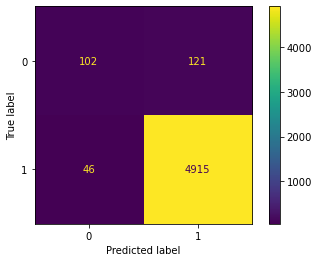

In [69]:
plot_confusion_matrix(rf_random, X_test, y_test)

C:\Users\Diego Ojeda\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


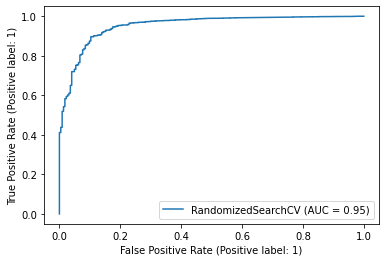

In [70]:
from sklearn import metrics
metrics.plot_roc_curve(rf_random, X_test, y_test)

#### 3.2.4 Guardado Del Modelo

In [282]:
pickle.dump(rf_random, open('rf.sav', 'wb'))
pickle.dump(vectorizer,open("vectorizer.sav","wb"))
pickle.dump(le,open("label_encoder.sav","wb"))

## 4. Uso Del Modelo

### 4.1 Cargue Del Modelo

In [284]:
model_rf = pickle.load(open("rf.sav", 'rb'))
vectorizer = pickle.load(open("vectorizer.sav", 'rb'))
le = pickle.load(open("label_encoder.sav", 'rb'))
model_rf.best_estimator_
le

RandomForestClassifier(bootstrap=False, max_depth=55, max_features='sqrt',
                       min_samples_split=10, n_estimators=400)

LabelEncoder()

### 4.2 Predicción Sobre Un Pozo

#### 4.2.1 Funcion De Seleccion Y Transformacion Para Uso Del Modelo

In [255]:
def pre_pro_well(base,well):
    '''
    FUNCION QUE SELECCIONA UN POZO, TRANSFORMA LOS DATOS COMO INPUT DEL MODELO

    - base: Dataframe con los datos de todos los pozos.
    - well: cadena de caracteres con el nombre del pozo a evaluar    
    '''

    base = base[base["Nombre"]==well]

    X = base["Operación"]

    nltk.download('wordnet')
    documents = []
    
    stemmer = WordNetLemmatizer()

    for sen in range(0, len(X)):

        # Removemos los caracteres especiales
        document = re.sub(r'\W', ' ', str(X[sen]))
        
        # Removemos todos las cadenas de caracteres de un solo caracter
        document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
        
        # Removemos caracteres sencillso al inicio
        document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
        
        # Substituimos dobles espacios por espacios sencillos
        document = re.sub(r'\s+', ' ', document, flags=re.I)

        # Removemos caracteres numericos
        document = re.sub(r'\[[0-9]*\]',' ',document)
        
        # Convertimos todo a minusculas
        document = document.lower()
        
        # Realizamos Lematizacion
        document = document.split()

        document = [stemmer.lemmatize(word) for word in document]
        document = ' '.join(document)
        
        documents.append(document)
    
    return (documents,base)

documents = pre_proccess(X)

[nltk_data] Downloading package wordnet to C:\Users\Diego
[nltk_data]     Ojeda\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [256]:
# Preparamos los datos para la prediccion sobre un pozo especifico
X_val,base_val = pre_pro_well(base,"MOR BL 04")
X_val

[nltk_data] Downloading package wordnet to C:\Users\Diego
[nltk_data]     Ojeda\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


['hang tbg on 7 1 16 casing head disconnected flow line and d bell nipple d bop stack adapter spool fish string andinstalled 7 1 16 pumping flange and 1 ea gate valve and top cap released mec 3 rig by completion operation 11 00 hr may 25 nd 2011',
 'rih 2 7 8 tubing eue 31 62 ft niplesilla 0 65 ft 86 jts 2 7 8 eue tubing 2676 55 ft rih joint to joint from surface to 2719 42 ft',
 'contd pooh and d 3 1 2 dp setting tool 2 7 8 tubing 1114 ft to surface d drill pipe to rack released mec 3 rig by drilling operation 02 30 hr may 25 th 2011',
 'gravel packing 5½ liner 10 16 mesh gravel from 152 sx to 200 sx 80 65 of theorical 248 sxs 4 min sx 37 spm 120 gpm spp 250 psi',
 'conditioned brine to 9 5 ppg and circulated and homogenize brine from 9 2 ppg to 9 4 ppg cheched flow ok',
 'set metal seal 5000 lb released setting tool 11 rigth turn pumped 20 bbl of water a spacer displaced mud by nacl brine 9 4 ppg washed shaker and pill tank circulating to homogenize brine to 9 4 ppg',
 'contd pooh an

In [257]:
X_val = vectorizer.transform(X_val)
X_val

<112x1500 sparse matrix of type '<class 'numpy.int64'>'
	with 2128 stored elements in Compressed Sparse Row format>

#### 4.2.2 Predicción Sobre Los Datos Pre-Procesados

In [258]:
y_val = model_rf.predict(X_val)
y_val

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0])

In [259]:
le.inverse_transform(y_val)

array(['OCM', 'OCM', 'ODR', 'ODR', 'ODR', 'ODR', 'ODR', 'ODR', 'ODR',
       'ODR', 'ODR', 'ODR', 'ODR', 'ODR', 'ODR', 'ODR', 'ODR', 'ODR',
       'ODR', 'ODR', 'ODR', 'ODR', 'ODR', 'ODR', 'ODR', 'ODR', 'ODR',
       'ODR', 'ODR', 'ODR', 'ODR', 'ODR', 'ODR', 'ODR', 'ODR', 'ODR',
       'ODR', 'ODR', 'ODR', 'ODR', 'ODR', 'ODR', 'ODR', 'ODR', 'ODR',
       'OCM', 'ODR', 'ODR', 'ODR', 'ODR', 'ODR', 'ODR', 'ODR', 'ODR',
       'ODR', 'ODR', 'ODR', 'ODR', 'ODR', 'ODR', 'ODR', 'ODR', 'ODR',
       'ODR', 'ODR', 'ODR', 'ODR', 'ODR', 'ODR', 'ODR', 'ODR', 'ODR',
       'ODR', 'ODR', 'ODR', 'ODR', 'ODR', 'ODR', 'ODR', 'ODR', 'ODR',
       'ODR', 'ODR', 'ODR', 'ODR', 'ODR', 'ODR', 'ODR', 'ODR', 'ODR',
       'ODR', 'ODR', 'ODR', 'ODR', 'ODR', 'ODR', 'ODR', 'ODR', 'ODR',
       'ODR', 'ODR', 'ODR', 'ODR', 'ODR', 'ODR', 'ODR', 'ODR', 'ODR',
       'ODR', 'ODR', 'OCM', 'OCM'], dtype='<U3')

In [260]:
base_val["Target"] = le.inverse_transform(y_val)
base_val

C:\Users\DIEGOO~1\AppData\Local\Temp/ipykernel_8012/2377140806.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_val["Target"] = le.inverse_transform(y_val)


,Siglas,Nombre,Desde,Hasta,MD From (ft),MD to (ft),Codigo,Subcodigo,Operación,Target
0,ODR,MOR BL 04,2011-05-25 08:00:00,2011-05-25 11:00:00,2773.0,2773.0,1300,1304.0,"HANG TBG ON 7 1/16"" CASING HEAD. DISCONNECTED ...",OCM
1,ODR,MOR BL 04,2011-05-25 02:30:00,2011-05-25 08:00:00,2773.0,2773.0,1100,1117.0,"RIH 2 7 /8"" TUBING EUE (31.62 FT) + NIPLESILL...",OCM
2,ODR,MOR BL 04,2011-05-25 00:00:00,2011-05-25 02:30:00,2773.0,2773.0,1100,1116.0,CONTD. POOH AND L/D 3 1/2'' DP + SETTING TOOL ...,ODR
3,ODR,MOR BL 04,2011-05-24 00:00:00,2011-05-24 03:30:00,2773.0,2773.0,1500,1503.0,"GRAVEL PACKING 5½"" LINER W/ 10-16 MESH GRAVEL ...",ODR
4,ODR,MOR BL 04,2011-05-24 21:30:00,2011-05-24 22:30:00,2773.0,2773.0,1500,1503.0,CONDITIONED BRINE TO 9.5 PPG AND CIRCULATED AN...,ODR
...,...,...,...,...,...,...,...,...,...,...
107,ODR,MOR BL 04,2011-05-18 02:30:00,2011-05-18 03:30:00,2773.0,2773.0,1100,1107.0,L/D DIRECTIONAL TOOLS. NMDC + EM EMITTING SUB+...,ODR
108,ODR,MOR BL 04,2011-05-18 14:30:00,2011-05-18 15:00:00,2773.0,2773.0,1500,1503.0,CIRCULATED @ 2305 FT EXCESS OF SPECIAL HI-VISC...,ODR
109,ODR,MOR BL 04,2011-05-18 12:00:00,2011-05-18 13:30:00,2773.0,2773.0,1800,1801.0,"CIRCULATED TO CLEAN RETURNS, WHILE WAITING ORD...",ODR
110,OCM,MOR BL 04,2011-05-25 02:30:00,2011-05-25 08:00:00,2773.0,2773.0,1100,1164.0,"RIH 2 7 /8"" TUBING EUE (31.62 FT) + NIPLESILL...",OCM


In [261]:
base_val = base_val[['Siglas', 'Target', 'Nombre', 'Desde', 'Hasta',"MD From (ft)","MD to (ft)","Codigo","Subcodigo","Operación"]]

In [263]:
base_val.sort_values(by=['Desde'])[100:]

,Siglas,Target,Nombre,Desde,Hasta,MD From (ft),MD to (ft),Codigo,Subcodigo,Operación
7,ODR,ODR,MOR BL 04,2011-05-24 09:30:00,2011-05-24 13:00:00,2773.0,2773.0,1100,1116.0,"POOH 3 1/2"" DP + GRAVEL PACKER + 2 7/8"" TBG FR..."
13,ODR,ODR,MOR BL 04,2011-05-24 13:00:00,2011-05-24 17:00:00,2773.0,2773.0,1100,1117.0,"M/U FLUTE AND RIH 2 7/8"" TUBING AS STINGER TO ..."
5,ODR,ODR,MOR BL 04,2011-05-24 17:00:00,2011-05-24 18:30:00,2773.0,2773.0,1200,1207.0,SET METAL SEAL W/5000 LBS. RELEASED SETTING TO...
12,ODR,ODR,MOR BL 04,2011-05-24 18:30:00,2011-05-24 20:30:00,2773.0,2773.0,1100,1116.0,POOH WASHING W/ FLUTE 5-1/2'' LINER JOINT TO J...
6,ODR,ODR,MOR BL 04,2011-05-24 20:30:00,2011-05-24 21:30:00,2773.0,2773.0,1100,1116.0,CONTD. POOH AND L/D 3 1/2'' DP + SETTING TOOL ...
4,ODR,ODR,MOR BL 04,2011-05-24 21:30:00,2011-05-24 22:30:00,2773.0,2773.0,1500,1503.0,CONDITIONED BRINE TO 9.5 PPG AND CIRCULATED AN...
11,ODR,ODR,MOR BL 04,2011-05-24 22:30:00,2011-05-25 00:00:00,2773.0,2773.0,1100,1116.0,CONTD. POOH AND L/D 3 1/2'' DP + SETTING TOOL ...
2,ODR,ODR,MOR BL 04,2011-05-25 00:00:00,2011-05-25 02:30:00,2773.0,2773.0,1100,1116.0,CONTD. POOH AND L/D 3 1/2'' DP + SETTING TOOL ...
1,ODR,OCM,MOR BL 04,2011-05-25 02:30:00,2011-05-25 08:00:00,2773.0,2773.0,1100,1117.0,"RIH 2 7 /8"" TUBING EUE (31.62 FT) + NIPLESILL..."
110,OCM,OCM,MOR BL 04,2011-05-25 02:30:00,2011-05-25 08:00:00,2773.0,2773.0,1100,1164.0,"RIH 2 7 /8"" TUBING EUE (31.62 FT) + NIPLESILL..."
